In [1]:
#Versions used in the notebook if CUDA 11.1 is available
#torch==1.10.0+cu111
#torchvision==0.11.1+cu111

# if cuda is not available
#!pip install torch==1.10.2
#!pip install torchvision==0.11.3

#comman libraries
#!pip install numpy==1.19.5
#!pip install matplotlib==3.2.2

---

In [1]:
# Importing required libraries
import torch
from tqdm import tqdm
import numpy as np
import copy
torch.manual_seed(0)
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

---

# Function to transform and load the data with Torch

In [2]:
def get_dl(batch_size):
    # Define transformations to convert the data to Tensors
    train_transforms = transforms.Compose([transforms.ToTensor()])

    # Downloading the training and testing MNIST Data and transforming it to tensors
    train_data = MNIST(root="./train/", train=True, download=True, transform=train_transforms)
    test_data = MNIST(root="./test/", train=False, download=True, transform=train_transforms)

    # Accessing the data and label of the first element in the dataset (commented out)
    # data, label = train_data[0]

    # Creating DataLoader objects to load the data in batches
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=True, drop_last=True)
    
    # Returning the training and testing data loaders
    return train_loader, test_loader


---

# Building Autoencoders model

In [3]:
import torch
import torch.nn as nn

# Encoder for Autoencoder
class Encoder(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.batchsize = batch_size
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, 2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.LRelu = nn.LeakyReLU()
        self.fc1 = nn.Linear(3136, 2)

    # Forward propagation function
    def forward(self, x):
        layer1 = self.LRelu(self.conv1(x))
        layer2 = self.LRelu(self.conv2(layer1))
        layer3 = self.LRelu(self.conv3(layer2))
        layer4 = self.LRelu(self.conv4(layer3))
        flat = layer4.view(self.batchsize, -1)
        flat_shape = flat.size()[1]
        encoder_out = self.fc1(flat)
        return encoder_out

# Decoder for Autoencoder
class Decoder(nn.Module):
    def __init__(self, batch_size):
        super().__init()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(2, 3136)
        self.Dconv1 = nn.ConvTranspose2d(64, 64, 3, 1, padding=1)
        self.Dconv2 = nn.ConvTranspose2d(64, 64, 3, 2, padding=1, output_padding=1)
        self.Dconv3 = nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1)
        self.Dconv4 = nn.ConvTranspose2d(32, 1, 3, 1, padding=1)
        self.LRelu = nn.LeakyReLU()
    
    # Forward propagation function
    def forward(self, x):
        fc = self.fc1(x)
        reshaped = fc.view(self.batch_size, 64, 7, 7)
        layer1 = self.LRelu(self.Dconv1(reshaped))
        layer2 = self.LRelu(self.Dconv2(layer1))
        layer3 = self.LRelu(self.Dconv3(layer2))
        layer4 = self.Dconv4(layer3)
        out = torch.sigmoid(layer4)
        return out

class Encoder_Decoder_model(nn.Module):
    def __init__(self, batch_size):
        super().__init()
        self.batch_size = batch_size

        # Initialize object for Encoder
        self.enc = Encoder(self.batch_size)

        # Initialize object for Decoder
        self.dec = Decoder(self.batch_size)
        self.sigmoid_act = torch.nn.Sigmoid()

    # Forward propagation function
    def forward(self, img):
        # img as input for encoder
        enc_out = self.enc(img)
        
        # Encoder output as input for decoder
        dec_out = self.dec(enc_out)
        out = self.sigmoid_act(dec_out)
        return out, self.dec


---

# Model Training

In [4]:
# Function to train the model
def train_model(no_of_epoch, model, dataloaders, optimizer, lossfn):
    # Setting the device (GPU if available, otherwise CPU)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    best_loss = 100000000.0

    # For each epoch, the model will be trained or evaluated
    for epoch in range(no_of_epoch):
        print('Epoch {}/{}'.format(epoch + 1, no_of_epoch))
        print('-' * 10)
        for phase in ['train', 'valid']:
            train_loss = []
            valid_loss = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            for inputs, labels in dataloaders[phase]:
                # Putting inputs and labels on the device
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # Training the model with the given inputs if the phase is 'train'
                    gen_img, dec_model = model(inputs)
                    # Calculating the loss
                    loss = lossfn(gen_img, inputs)
                    if phase == 'train':
                        # Backpropagation during training
                        loss.backward()
                        optimizer.step()
                        train_loss.append(loss.detach().cpu().numpy())
                    else:
                        valid_loss.append(loss.detach().cpu().numpy())
            # Printing the loss
            if phase == 'train':
                print("Train Loss: {}".format(np.mean(train_loss)))
            else:
                print("Valid Loss: {}".format(np.mean(valid_loss)))

    return model, dec_model


In [5]:
# Set a random seed for reproducibility
torch.manual_seed(0)

# Parameters for model building
batchsize = 128  # Batch size for data loading
n_epoch = 10  # Number of training epochs

# Downloading and transforming the data using a function named get_dl
train_loader, test_loader = get_dl(batchsize)

# Putting data loaders into a dictionary for training and validation
dl = {}
dl["train"] = train_loader
dl["valid"] = test_loader

# Create an autoencoder model
model = Encoder_Decoder_model(batchsize)

# Define the device for model training (use GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Learning rate for the optimizer
lr = 0.001

# Select the Adam optimizer with weight decay
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

# Mean Squared Error (MSE) loss function
loss_fn = torch.nn.MSELoss()

# Train the model using the defined training function
model, dec_model = train_model(n_epoch, model, dl, optim, loss_fn)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw

Epoch 1/10
----------
Train Loss : 0.057532936334609985
Valid Loss : 0.0470893457531929
Epoch 2/10
----------
Train Loss : 0.045323364436626434
Valid Loss : 0.04404744133353233
Epoch 3/10
----------
Train Loss : 0.043188780546188354
Valid Loss : 0.04289012774825096
Epoch 4/10
----------
Train Loss : 0.041983891278505325
Valid Loss : 0.041681062430143356
Epoch 5/10
----------
Train Loss : 0.04112017899751663
Valid Loss : 0.04089677706360817
Epoch 6/10
----------
Train Loss : 0.04051031917333603
Valid Loss : 0.040405843406915665
Epoch 7/10
----------
Train Loss : 0.04010498896241188
Valid Loss : 0.040272586047649384
Epoch 8/10
----------
Train Loss : 0.039789050817489624
Valid Loss : 0.03984377160668373
Epoch 9/10
----------
Train Loss : 0.039506927132606506
Valid Loss : 0.03960197791457176
Epoch 10/10
----------
Train Loss : 0.03929963707923889
Valid Loss : 0.03947124257683754


In [6]:
# Function to plot and display an image
def show_image(img):
    # Convert the PyTorch tensor to a NumPy array
    npimg = img.numpy()
    
    # Rearrange the dimensions of the array for proper display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


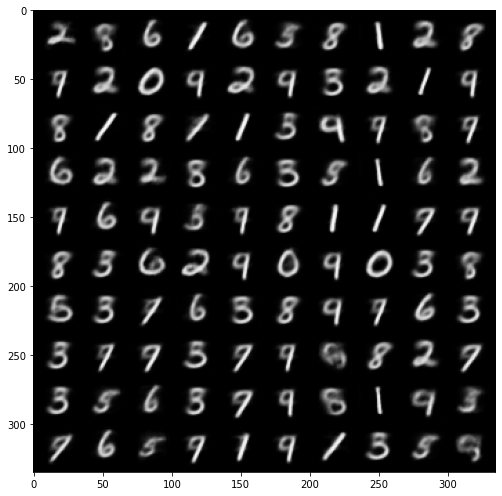

In [8]:
# Get a batch of data and labels from the data loader
data_batch, labels_batch = next(iter(train_loader))

# Move the data batch to the device (GPU or CPU)
data_batch = data_batch.to(device)

# Pass the data through the autoencoder model to get the reconstructed images
img_recon, dec = model(data_batch)

# Move the reconstructed images to CPU for visualization
img_recon = img_recon.cpu()

# Create a figure and axis for displaying the images
fig, ax = plt.subplots(figsize=(20, 8.5))

# Show the reconstructed images using the 'show_image' function
show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))

plt.show()


In [18]:
# Original labels of data
labels_batch

tensor([2, 3, 6, 1, 6, 2, 1, 1, 2, 8, 4, 2, 0, 9, 2, 4, 3, 2, 1, 9, 8, 1, 8, 7,
        1, 5, 9, 4, 8, 7, 6, 2, 2, 8, 6, 3, 5, 1, 6, 2, 7, 6, 4, 5, 7, 9, 1, 1,
        4, 9, 5, 3, 0, 2, 9, 0, 4, 0, 3, 3, 3, 3, 9, 6, 3, 8, 4, 4, 6, 3, 5, 4,
        7, 3, 9, 4, 7, 8, 2, 7, 5, 5, 6, 3, 4, 4, 8, 1, 7, 1, 7, 6, 5, 8, 7, 9,
        1, 3, 5, 7, 3, 5, 9, 1, 1, 6, 8, 1, 6, 6, 5, 1, 0, 7, 0, 8, 0, 9, 1, 7,
        9, 0, 0, 4, 0, 8, 9, 0])

In [10]:
# Decoder model
dec

Decoder(
  (fc1): Linear(in_features=2, out_features=3136, bias=True)
  (conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LReLU): LeakyReLU(negative_slope=0.01)
)

---

# Decoder as Generative Model

In [11]:
# Creating a random latent vector with a shape of (128, 2)
latent = torch.randn(128, 2) * 1 + 0

tensor([[-0.1334, -0.7562],
        [-1.0450, -0.7232],
        [ 0.2219, -1.5370],
        [-0.7099, -0.8578],
        [ 0.3247,  0.9180],
        [-0.2274, -0.4788],
        [ 2.2965,  0.3921],
        [ 0.5432,  0.7078],
        [-1.0376, -0.4702],
        [-0.8927,  0.0124],
        [-0.6796, -0.4071],
        [-2.1010,  0.7313],
        [ 0.0571, -0.0648],
        [-0.1227, -1.9667],
        [ 0.5005, -1.2564],
        [-0.4628,  0.2127],
        [ 0.7428,  0.9084],
        [-0.3088,  0.5737],
        [ 0.7756,  0.2723],
        [-1.4298,  1.1736],
        [ 0.4415, -1.0671],
        [-0.7489, -0.6982],
        [-1.1154, -0.1959],
        [ 0.1679, -0.1687],
        [ 0.8347, -1.5563],
        [-0.6364,  0.4985],
        [ 1.2004, -1.3274],
        [-0.3953,  1.1468],
        [ 1.1127,  0.7129],
        [-1.2343,  0.9052],
        [-0.3778, -0.7885],
        [ 1.4601,  0.7611],
        [ 1.9843,  0.4991],
        [ 1.8642, -0.0530],
        [ 0.4592, -0.6944],
        [-0.7104, -0

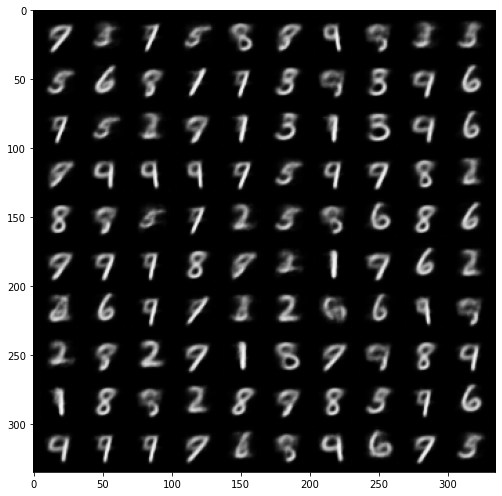

In [12]:
# Move the latent vectors to the device (GPU or CPU)
latent = latent.to(device)

# Generate images using the decoder model
img_recon = dec(latent)

# Move the reconstructed images to CPU for visualization
img_recon = img_recon.cpu()

# Create a figure and axis for displaying the images
fig, ax = plt.subplots(figsize=(20, 8.5))

# Show the reconstructed images using the 'show_image' function
show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))

plt.show()


---